In [1]:
import os

import numpy as np
import png
from matplotlib import pyplot as plt
import sklearn as sk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

In [29]:
def read_image(filename: str) -> np.array:
    im = png.Reader(filename)
    im_data = im.read()
    im_2d = np.vstack(list(map(np.int64, im_data[2])))
    im_3d = im_2d.reshape((im_data[0], im_data[1], im_data[3]['planes']))
    # plt.imshow(im_3d)
    return im_3d

In [30]:
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
images = np.array([read_image(f"Data/images_original/{genre}/{genre}{i:05d}.png")
          for genre in genres[:2]
          for i in range(1, 10)
         ])

In [52]:
class GenreImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
        self.examples = 100
        self.transform = transform
    
    def __len__(self):
        return len(self.genres) * self.examples
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            raise ValueError("cannot take tensor index")
            
        genre_idx = int(idx // self.examples)
        genre_str = self.genres[genre_idx]
        example_idx = idx % self.examples
        img_name = os.path.join(self.dataset_path,
                                "images_original",
                                genre_str,
                                f"{genre_str}{example_idx:05d}.png")
        image_data = read_image(img_name)
            
        sample = [np.transpose(image_data, (2, 0, 1)) / 255, genre_idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

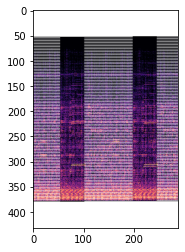

In [56]:
genre_dataset = GenreImageDataset("Data")
dataloader = DataLoader(genre_dataset,
                        batch_size=4,
                        shuffle=True, 
                        num_workers=0)
dataiter = iter(dataloader)
images, labels = dataiter.next()

plt.imshow(np.transpose(images[0], (1, 2, 0)))

In [72]:
class Net(nn.Module):
    def __init__(self):
        self.linear_layer_size = 16 * 25 * 16
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 8, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(self.linear_layer_size, 1024)
        self.fc2 = nn.Linear(1024, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, self.linear_layer_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(4, 8, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [75]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs = data[0].to(device).float()
        labels = data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print_interval = 50
        if i % print_interval == print_interval - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_interval))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.304
[1,   100] loss: 2.304
[1,   150] loss: 2.304
[1,   200] loss: 2.305
[1,   250] loss: 2.304
[2,    50] loss: 2.303
[2,   100] loss: 2.303
[2,   150] loss: 2.300
[2,   200] loss: 2.305
[2,   250] loss: 2.304
Finished Training


In [63]:
for i, data in enumerate(dataloader):
    inputs, labels = data
    print(labels)
    output = model(inputs.to(device).float())
    print(outputs)
    break

tensor([1, 5, 5, 1])
tensor([[ 0.2609,  0.0373,  0.6036,  0.4366,  0.3051,  0.2634, -0.3542,  0.0125,
          0.0840, -0.1410],
        [ 0.2657,  0.2570,  0.4990,  0.3126,  0.3876,  0.3177, -0.6266,  0.0354,
          0.1274, -0.2956],
        [ 0.2385, -0.0359,  0.6156,  0.4727,  0.2660,  0.2377, -0.2312,  0.0109,
          0.0598, -0.0794],
        [ 0.2952,  0.2311,  0.5484,  0.3313,  0.3810,  0.3142, -0.6567,  0.0459,
          0.1140, -0.2907]], device='cuda:0', grad_fn=<AddmmBackward>)
